In [1]:
import sys
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.spatial import ConvexHull
from sklearn.manifold import MDS #If you want the scikit learn mds
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay,classification_report
import HiCtoolbox
from hmmlearn import hmm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import h5py


In [2]:
filename="Chr22_100kb.txt"
R=100000


In [3]:
#binning 
def binning_intra(filename,R):
    contacts=pd.read_csv(filename, sep="\t",header=None)# <-  here  acces to data ,write the filename you wish  
    min_val=contacts.iloc[:,:2].min().min()
    max_val=contacts.iloc[:,:2].max().max()
    contacts=np.int_(np.array(contacts))
    
    contacts=np.concatenate((contacts,np.transpose(np.array([contacts[:,1],contacts[:,0],contacts[:,2]]))), axis=0)#flipping rows to keep full data  @ taken from Leopold
    contacts= sparse.coo_matrix( (contacts[:,2], (contacts[:,0],contacts[:,1]))) # need sparse becaus eof big volume of some matrices
    binned_map=HiCtoolbox.bin2d(contacts,R,R) #!become csr sparse array, taken from leopold
    del contacts
    
  
    return binned_map,min_val,max_val

In [4]:
binned_map,min_val,max_val=binning_intra(filename,R)



In [5]:
#filtering
def filter(binned_map):
    filtered_map,bin_sel=HiCtoolbox.filteramat(binned_map)
    
    return filtered_map,bin_sel

In [6]:
filtered_map,bin_sel=filter(binned_map)

In [7]:
# SCN
def SCN(filtered_map):
    scn_map=HiCtoolbox.SCN(filtered_map.copy()) 
    return scn_map

In [8]:
scn_map=SCN(filtered_map)

In [9]:
# Diagonals normalisation
def diagonals(scn_map):
    mean=[]
    n=scn_map.shape[0]
    contact_map=np.zeros((n,n))

    mean=[np.mean(scn_map.diagonal(i)) for i in range(-n+1,n)]
    for i in range(n):
        for j in range(n):
            contact_map[i, j] = scn_map[i,j]/mean[j-i+n-1]
    return contact_map

In [10]:
contact_map=diagonals(scn_map)

<AxesSubplot:>

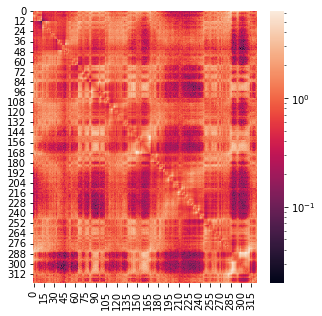

In [11]:
# visualisation of contact map
plt.figure(figsize=(5, 5)) 
sns.heatmap(contact_map, norm=LogNorm())

In [12]:
#Correlations matrix - excluding filtered bins
def correlations(contact_map):
    corr_mat=np.corrcoef(np.array(contact_map)) # calcul of Pearson correlation
    corr_mat=np.nan_to_num(corr_mat, nan=0.0)
    return corr_mat

In [13]:
corr_mat=correlations(contact_map)

<AxesSubplot:>

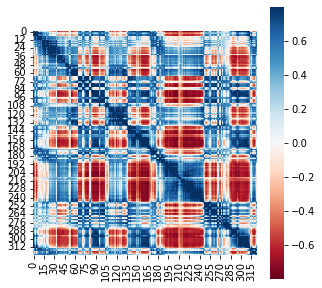

In [14]:
#visualisation filtered correlation matrix
plt.figure(figsize=(5, 5)) 
v=np.min([abs(np.min(np.min(corr_mat))),abs(np.max(np.max(corr_mat)))])
sns.heatmap(corr_mat,cmap="RdBu",center=0,square=True,vmin=-1*v,vmax=v)

In [15]:
#Correlations matrix -including filtered bins with centromer
corr_mat_full=pd.DataFrame(np.zeros(binned_map.shape))
#corr_mat_full.iloc[:,:]=0
corr_mat_full.iloc[bin_sel,bin_sel]=corr_mat


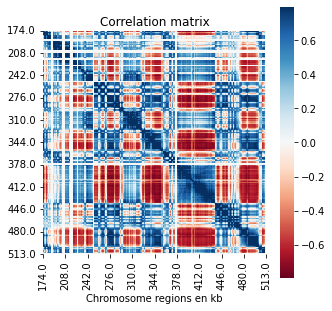

In [16]:
# visualisation -full matrix with centromer

plt.figure(figsize=(5, 5)) 
border=np.where(corr_mat_full>0)[0][0]  # elimation of zero zone 
nr_of_sticks=11
yticklabels = np.ceil(np.linspace(border,corr_mat_full.shape[0],nr_of_sticks))
xticklabels = np.ceil(np.linspace(border,corr_mat_full.shape[0],nr_of_sticks))
yticks = np.linspace(0,corr_mat_full.shape[0]-border,nr_of_sticks)
xticks = np.linspace(0,corr_mat_full.shape[0]-border,nr_of_sticks)
v=np.min([abs(np.min(np.min(corr_mat_full))),abs(np.max(np.max(corr_mat_full)))]) # color bar cutt of 

ax=sns.heatmap(corr_mat_full.iloc[border:,border:],cmap="RdBu",center=0,square=True,vmin=-1*v,vmax=v)
ax.set_yticks(yticks)
ax.set_xticks(xticks)
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)
plt.xlabel('Chromosome regions en kb')
ax.set_title("Correlation matrix")
plt.show()

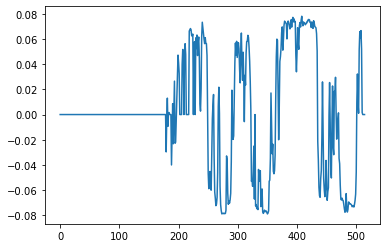

In [17]:
# SPECTRAL ANALYSIS
# Gold standard eigenvector
gold_ev=pd.read_csv("chr22_VP.txt", sep="\t",header=None) # HERE GOLD STANDARD COMPARTEMENT
gold_ev.loc[gold_ev[0]==-1]=0
plt.plot(np.arange(gold_ev.shape[0]),gold_ev)
plt.show()



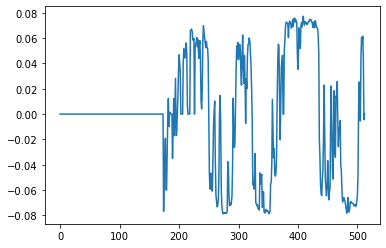

In [18]:
#EIGENVECTORS full matrix
eigenvalue_full, eigenvector_full=np.linalg.eig(corr_mat_full)
eigenvector_full= eigenvector_full.T
plt.plot(np.arange(len(eigenvector_full[0])),eigenvector_full[0]) 
#plt.plot(np.arange(len(eigenvector_full[0])),-1*eigenvector_full[0])# in case eigenvector is flliped, upside-down
plt.show()

In [20]:
# saving to file
columns=["startPOS","endPOS","cptTYPE"]
startPOS=np.arange(0,eigenvector_full[0].shape[0]*R,R).reshape(1,-1)
endPOS=np.arange(R,(eigenvector_full[0].shape[0]+1)*R,R).reshape(1,-1)
cptTYPE=np.sign(eigenvector_full[0]).reshape(1,-1)
compartments=pd.DataFrame(np.concatenate([startPOS,endPOS,cptTYPE]).T)
compartments.columns=columns
compartments["chr i"]="chr 1" # HERE CHANGE TO ADEQUATE COMPARTEMENT
cols = list(compartments.columns)
cols = [cols[-1]] + cols[:-1]
compartments= compartments[cols]
compartments

,chr i,startPOS,endPOS,cptTYPE
0,chr 1,0.0,100000.0,0.0
1,chr 1,100000.0,200000.0,0.0
2,chr 1,200000.0,300000.0,0.0
3,chr 1,300000.0,400000.0,0.0
4,chr 1,400000.0,500000.0,0.0
...,...,...,...,...
508,chr 1,50800000.0,50900000.0,1.0
509,chr 1,50900000.0,51000000.0,1.0
510,chr 1,51000000.0,51100000.0,1.0
511,chr 1,51100000.0,51200000.0,-1.0


In [ ]:
filename="Chr22_cpts" # HERE SAVE THE FILE
np.savetxt(filename,compartements)